# Arima
Данные взяты после сезонного дифференирования и дифференцирования со сдвигом на единицу.  
Будет использована модель типа Sarima(p,d,q)x(P,D,Q) для предсказания цены закрытия дня по еродоллору.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('data_Arima.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
df.head()

,close
date,
2011-05-10,-0.006972
2011-05-11,-0.008897
2011-05-12,0.000497
2011-05-13,-0.004880
2011-05-16,-0.000116


In [3]:
df.index = pd.DatetimeIndex(df.index).to_period('D')
df.head()

,close
date,
2011-05-10,-0.006972
2011-05-11,-0.008897
2011-05-12,0.000497
2011-05-13,-0.004880
2011-05-16,-0.000116


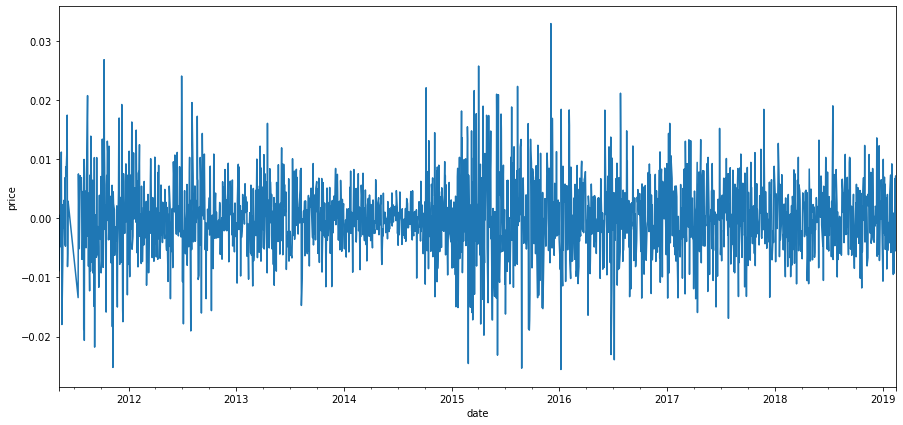

In [4]:
plt.figure(figsize(15,7))
df.close.plot() 
plt.ylabel('price')
pylab.show()

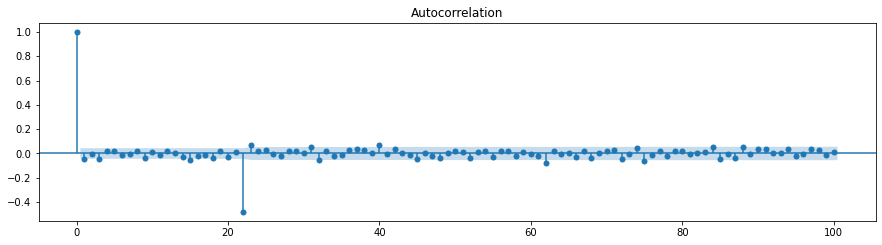

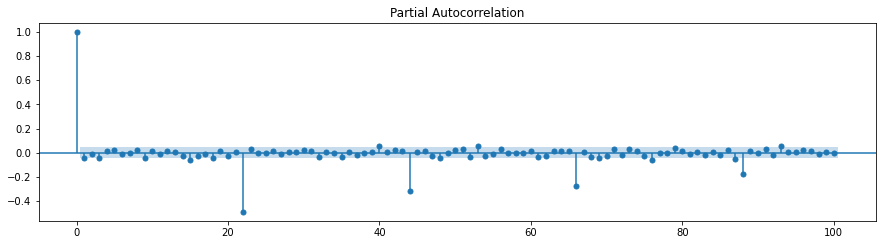

In [5]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['close'].values.squeeze(), lags=100, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['close'].values.squeeze(), lags=100, ax=ax)
pylab.show()

In [6]:
df_orig = pd.read_csv('forex.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
_ , lmbda = stats.boxcox(df_orig['close'])

In [7]:
df_orig.index = pd.DatetimeIndex(df_orig.index).to_period('D')

q = 1 так как на графики автокорреляции только один значимый несозонный лаг - лаг номер один
Q = 1 12 - значимый сезонных лагов на первом графике
p = 1 на графике частичной автокорреляции значим исключительно первый лаг 
P = 4 - на втором графике значим сезонный лаг 48, в то время как сезонный период равен 12

12.05.21

q = 5 так как на графики автокорреляции последний значимый несозонный лаг - лаг номер пять
Q = 1 - лаг 12 - значимый сезонных лагов на графике автокорреляции
p = 5 на графике частичной автокорреляции последним значимым (и несезонным) является 5 лаг
P = 1 - на втором графике значим сезонный лаг 12, в то время как сезонный период равен 12

19.05.21  
все единички (двойки)

In [8]:
qs = range(0,2)
Qs = range(0,1)
ps = range(0,2)
Ps = range(0,1)

d = 1
D = 1

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.close, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 22)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 12.5 s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
3  (1, 1, 0, 0) -12194.807435
1  (0, 1, 0, 0) -12190.374656
2  (1, 0, 0, 0) -11353.441032
0  (0, 0, 0, 0) -10707.059827


D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Анализ остатков

In [12]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                 2018
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 22)   Log Likelihood                6100.404
Date:                             Wed, 19 May 2021   AIC                         -12194.807
Time:                                     16:26:36   BIC                         -12178.012
Sample:                                 05-10-2011   HQIC                        -12188.640
                                      - 02-15-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0565      0.019     -3.027      0.002      -0.093      -0.020
ma.L1         -0.9999      

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.989176
Критерий Дики-Фуллера: p=0.000000


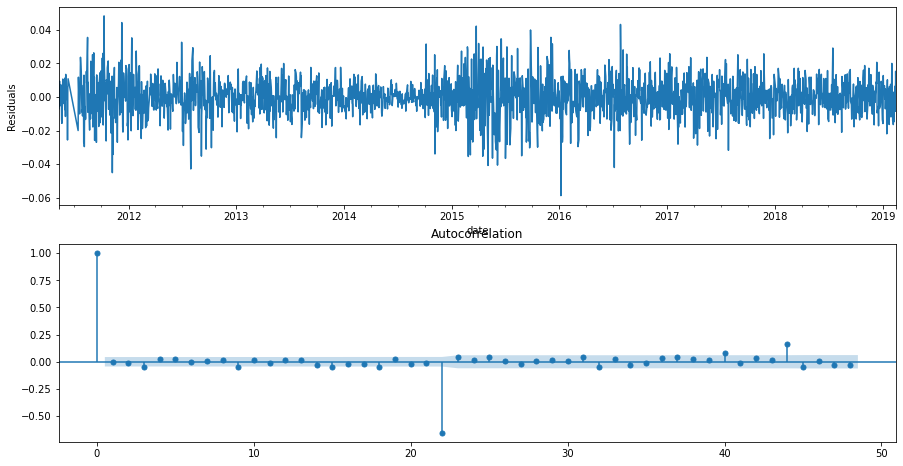

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

выводы

In [14]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
const = df['close'][10]/df.model[10:][1] / 12
bias = df['close'][10] - df.model[10:][1]
bias

AttributeError: 'DataFrame' object has no attribute 'model'

In [ ]:
#df.close, lmbda = stats.boxcox(np.abs(df['close']))

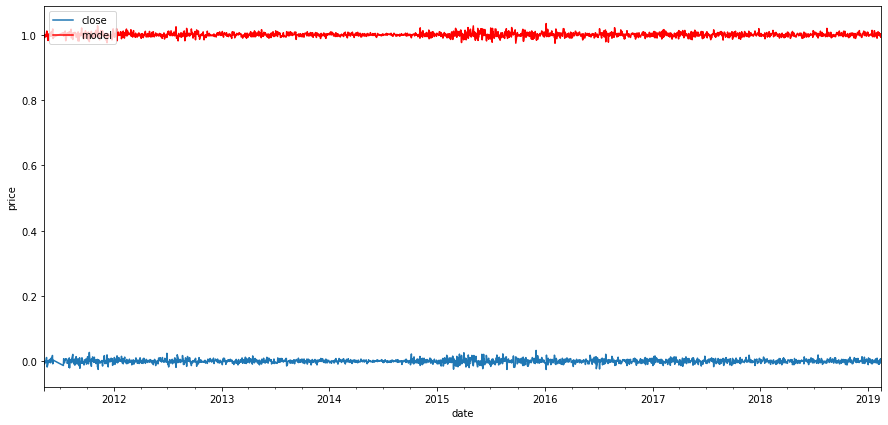

In [16]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df['close'].plot()#df.WAG_C_M.plot()
#df.close.plot(color='b')
#(df.model[13:]*const - np.abs(bias)).plot(color='r')
(df.model).plot(color='r')
plt.ylabel('price')
plt.legend(loc='upper left')
pylab.show()

In [17]:
result_table

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,parameters,aic
0,"(0, 0, 0, 0)",-10707.059827
1,"(0, 1, 0, 0)",-12190.374656
2,"(1, 0, 0, 0)",-11353.441032
3,"(1, 1, 0, 0)",-12194.807435


In [18]:
result_table.to_csv('result_arima_19_05.csv')

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Result

In [19]:
df.tail()

,close,model
date,,
2019-02-11,-0.000430,0.995539
2019-02-12,0.006716,1.000283
2019-02-13,-0.005517,1.003057
2019-02-14,0.007150,0.991926
2019-02-15,-0.002044,0.998201


In [20]:
#date_start = '18/02/19'
date_start = '2019-02-18'
date_end = '2019-04-21'

date_time_start = datetime.strptime(date_start, '%Y-%m-%d')
date_time_end = datetime.strptime(date_end, '%Y-%m-%d')

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
df_orig = pd.read_csv('forex.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)

In [22]:
df_new = pd.read_csv('EURUSD_D1.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
n_dt = df_new.index.to_list()
n_dt = n_dt[1297:1350]
n_dt = [i.date() for i in n_dt]
n_dt[:5]

[datetime.date(2019, 2, 19),
 datetime.date(2019, 2, 20),
 datetime.date(2019, 2, 21),
 datetime.date(2019, 2, 22),
 datetime.date(2019, 2, 24)]

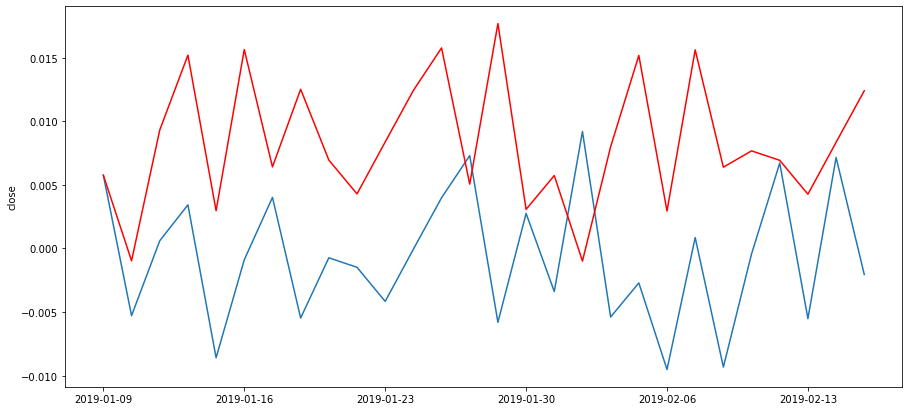

In [23]:
df2 = df[['close']][30:]
#date_list = [datetime.datetime.strptime("2011-05-10", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,30)]
future = pd.DataFrame(index=n_dt, columns= df2.columns)
df2 = pd.concat([df2, future])      #start=date_time_start,end=date_time_end
df2['forecast'] = invboxcox(best_model.predict(start=2800, end=2850), lmbda) #start=2040, end=2070
#df2.index = pd.DatetimeIndex(df2.index).to_period('D')

plt.figure(figsize(15,7))
df2.close[1960:1990].plot()
(df2.forecast[1960:1990] + (df2.close[1960]-df2.forecast[1960])).plot(color='r')
plt.ylabel('close')
pylab.show()

In [24]:
df2.close[1960]-df2.forecast[1960]

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.9907133161381805

In [26]:
#date_list = df_orig.index.to_list()
date_list = [datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
date_list[:5]

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[datetime.datetime(2016, 8, 1, 0, 0),
 datetime.datetime(2016, 9, 1, 0, 0),
 datetime.datetime(2016, 10, 1, 0, 0),
 datetime.datetime(2016, 11, 1, 0, 0),
 datetime.datetime(2016, 12, 1, 0, 0)]

In [27]:
best_model_table = pd.DataFrame(data=best_model, index_col=['date'], parse_dates=['date'], dayfirst=True)

TypeError: __init__() got an unexpected keyword argument 'index_col'

In [28]:
best_model_table.head()

NameError: name 'best_model_table' is not defined

In [ ]:
best_model_table.to_csv('arima_best_19_05.csv')